In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/RETINAL/

/content/drive/MyDrive/RETINAL


In [3]:
%ls

augment.ipynb  models/    outputs/  test.zip   training.zip  unet.ipynb
files/         new_data/  test/     training/  unet-2.ipynb


In [20]:
# Libraries

import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [5]:
# Utils

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [6]:
# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [7]:
# Loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [8]:
# Model

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

x = torch.randn((2, 3, 512, 512))
model = build_unet()
y = model(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [11]:
# Load pre-trained Model
model.load_state_dict(torch.load("models/unet.pth"))

<All keys matched successfully>

In [62]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in (loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return epoch_loss


In [14]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 4
num_epochs = 150
lr = 1e-4


Dataset Size:
Train: 400 - Valid: 20



In [21]:
""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

device = torch.device('cuda')
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [63]:
eval_loss = evaluate(model, train_loader, loss_fn, device)
print(f"evaluation loss for new train data : {eval_loss}")

evaluation loss for new train data : 1.582517408132553


In [17]:
create_dir("./outputs/")
create_dir("./outputs/unet")
create_dir("./outputs/unet/image")
create_dir("./outputs/unet/result")

In [56]:
i = 0

model.eval()
with torch.no_grad():
    for x, _ in train_loader:
      if i== 20:
        break
      for j in range(4):
        cv2.imwrite(f"outputs/unet/image/{i}-{j}.png", np.array(x[j]).transpose([1,2,0]))
      x = x.to(device, dtype=torch.float32)
      y_pred = model(x)
      for j in range(4):
        a = y_pred[j].to('cpu').squeeze()
        a = 255*(a-a.min())/(a.max()-a.min())
        a = np.array(a, dtype="uint8")
        cv2.imwrite(f"outputs/unet/result/{i}-{j}.png", a)

      i += 1

In [55]:
a = y_pred.to('cpu')[0].squeeze()
a = 255*(a-a.min())/(a.max()-a.min())
a.to(torch.uint8)

tensor([[184, 189, 206,  ..., 180, 164, 163],
        [ 87, 202, 161,  ..., 181, 113, 254],
        [149, 192, 198,  ..., 139, 124, 216],
        ...,
        [123, 248, 197,  ..., 209, 126, 255],
        [129, 164, 171,  ..., 122, 123, 214],
        [ 70, 154, 107,  ..., 120, 114, 231]], dtype=torch.uint8)

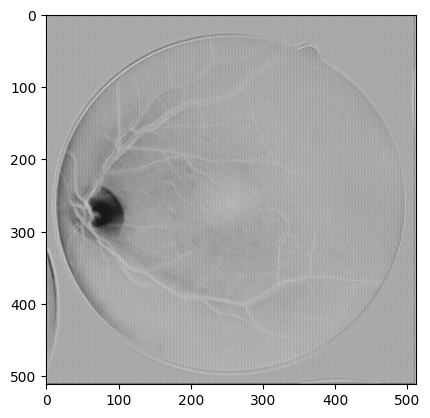

In [41]:
plt.imshow(a,'gray',
           vmax=255,vmin=0)

In [ ]:
def mask_parse(mask):
  mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
  mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
  return mask

def renorm(mask):
  mn = mask.min()
  mx = mask.max()
  mask = 255*(mask-mn)/(mx-mn)
  return mask

time_taken = []
model.eval()
for i, x  in enumerate(train_x):
  if i==20:
    break

  """ Extract the name """
  name = x.split("/")[-1].split(".")[0]

  """ Reading image """
  image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
  cv2.imwrite(f"./outputs/unet/image/{i}.png", image)
  ## image = cv2.resize(image, size)
  x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
  x = x/255.0
  x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
  x = x.astype(np.float32)
  x = torch.from_numpy(x)
  x = x.to(device)

  with torch.no_grad():
      """ Prediction and Calculating FPS """
      start_time = time.time()
      pred_y = model(x)
      # pred_y = torch.sigmoid(pred_y)
      total_time = time.time() - start_time
      time_taken.append(total_time)

      pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
      pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
      print("1:", pred_y.min(), pred_y.max())
      pred_y = renorm(pred_y)
      pred_y = pred_y > 0.5
      pred_y = np.array(pred_y*255, dtype=np.uint8)
      print('2: ', pred_y.min(), pred_y.max())

  """ Saving masks """
  pred_y = mask_parse(pred_y)

  cv2.imwrite(f"outputs/unet/result/{i}.png", pred_y)

print("mean time: ", np.mean(time_taken))

1: -0.12291881 -0.113077626
2:  0 255
1: -0.120862246 -0.11354889
2:  0 255
1: -0.12087087 -0.11438538
2:  0 255
1: -0.120876946 -0.11330003
2:  0 255
1: -0.12083252 -0.11349603
2:  0 255
1: -0.122946344 -0.1130783
2:  0 255
1: -0.12293338 -0.11272229
2:  0 255
1: -0.12304406 -0.11258076
2:  0 255
1: -0.12310955 -0.11316435
2:  0 255
1: -0.12226122 -0.111906335
2:  0 255
1: -0.12087742 -0.11273057
2:  0 255
1: -0.12085917 -0.11405827
2:  0 255
1: -0.12240405 -0.11197403
2:  0 255
1: -0.12287896 -0.11288087
2:  0 255
1: -0.122164235 -0.111101426
2:  0 255
1: -0.122861005 -0.11310038
2:  0 255
1: -0.12297594 -0.11273643
2:  0 255
1: -0.12104834 -0.11452871
2:  0 255
1: -0.12292545 -0.11258597
2:  0 255
1: -0.12083259 -0.11346763
2:  0 255
mean time:  0.007657849788665771


array([0], dtype=uint8)

In [ ]:
# Train

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader)+1e-5)
    return epoch_loss




""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 4
num_epochs = 150
lr = 1e-4
checkpoint_path = "files/checkpoint.pth"

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

device = torch.device('cuda')
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

""" Training the model """
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    # valid_loss = evaluate(model, valid_loader, loss_fn, device)

    """ Saving the model """
    if train_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {train_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = train_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    # data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Dataset Size:
Train: 1600 - Valid: 0

Valid loss improved from inf to 0.8432. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 7m 19s
	Train Loss: 0.843

Valid loss improved from 0.8432 to 0.5511. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 7m 12s
	Train Loss: 0.551



In [ ]:
torch.cuda.empty_cache()

1e-11

In [ ]:
# Test

import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("../new_data/test/image/*"))
    test_y = sorted(glob("../new_data/test/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

ModuleNotFoundError: No module named 'model'